In [272]:
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as functional
import torch
!pip install torch-fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64).cuda()

from PIL import Image
from IPython.display import display
import cv2

import random

import os

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
PATH = '/kaggle/input/celeba-dataset/img_align_celeba'

In [ ]:
transform = transforms.Compose([
    #resize the image to 64x64
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [ ]:

dataset = datasets.ImageFolder(PATH, transform=transform)


### The Generator class

In [ ]:
class Generator(nn.Module):
    
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    LATENT_DIM = 100
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            *self.__create_conv_layer(self.LATENT_DIM, 512, kernel_size=4, stride=1, padding=0),
            *self.__create_conv_layer(512, 256),
            *self.__create_conv_layer(256, 128),
            *self.__create_conv_layer(128, 64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=4, stride=2, padding=1) -> list:
        layer = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.ReLU(True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer

    def forward(self, x):
        return self.model(x)

The Discriminator class

In [ ]:
class Discriminator(nn.Module):
    
    LEAKY_RELU_SLOPE = 0.2
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    STARTING_SIZE = 64
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.convolutional_model = nn.Sequential(
            *self.__create_conv_layer(3, 64),
            *self.__create_conv_layer(64, 128),
            *self.__create_conv_layer(128, 256),
            *self.__create_conv_layer(256, 512),
        )
        
        self.flatten_size = self.__get_flatten_size()

        self.fully_connected_model = nn.Sequential(
            *self.__create_fully_connected_layer(self.flatten_size, 512),
            *self.__create_fully_connected_layer(512, 1),
            nn.Sigmoid()
        )
        
    def __get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, self.STARTING_SIZE, self.STARTING_SIZE)
        # Pass the dummy input through the convolutional layers
        dummy_result = self.convolutional_model(dummy_input)
        # Flatten the output to calculate the size
        flatten_size = dummy_result.view(-1).size(0)
        
        return flatten_size

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=3, stride=2, padding=1) -> list:
        layer = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace=True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer
        
    def __create_fully_connected_layer(self, in_features: int, out_features: int) -> list:
        layer = [nn.Linear(in_features, out_features), nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace = True)]
        
        return layer

    def forward(self, x):
        x = self.convolutional_model(x)
        x = x.view(-1, self.flatten_size)
        x = self.fully_connected_model(x)
        
        return x

In [ ]:
LEARNING_RATE_GENERATOR = 0.001
LEARNING_RATE_DISCRIMINATOR = 0.0003
MOMENTUM_B1 = 0.7
MOMENTUM_B2 = 0.999

loss_function = nn.BCELoss()
generator = Generator().cuda()
discriminator = Discriminator().cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), 
                                       lr=LEARNING_RATE_GENERATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                       )
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                       lr=LEARNING_RATE_DISCRIMINATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                        )



Load the model

In [ ]:
WORKING_PATH = "/kaggle/input/constk/"

generator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'generator')))
discriminator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'discriminator')))

In [ ]:
BATCH_SIZE = 25

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for i, (real_images, _) in enumerate(data_loader):
    real_images = real_images.cuda()

    shape = torch.Size((real_images.size(0), Generator.LATENT_DIM, 1, 1))
    noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
    noise = noise.cuda()
    
    for j in range(25):
        noise[j] = noise[0]
        noise[j][67] = ((j / 5) * 2) / 5 - 1
        noise[j][68] = ((j / 5) * 2) / 5 - 1
        noise[j][9] = ((j % 5) * 2) / 5 - 1
        noise[j][10] = ((j % 5) * 2) / 5 - 1
    
    generated_images = generator(noise)
    save_image(generated_images, f"/kaggle/working/sweep.png", nrow=5, normalize=True)
    img = Image.open(f"/kaggle/working/sweep.png")
    display(img)
    
    break

In [ ]:
EPOCHS = 200
K = 5
BATCH_SIZE = 32

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(data_loader):
        
        real_images = real_images.cuda()
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()
        
        shape = torch.Size((real_images.size(0), Generator.LATENT_DIM, 1, 1))
        noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
        noise = noise.cuda()
        generated_images = generator(noise)
        real_output = discriminator(real_images).cuda()
        fake_output = discriminator(generated_images).cuda()
        
        real_loss = loss_function(real_output, real_labels)
        fake_loss = loss_function(fake_output, fake_labels)
        discriminator_loss = real_loss + fake_loss
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        if i % K == 0:
            noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
            noise = noise.cuda()
            generated_images = generator(noise)
            output = discriminator(generated_images)
            
            # We use real_labels because we want to maximize log(D(G(z)))
            # which is equivalent to minimizing log(1-D(G(z)))
            generator_loss = loss_function(output, real_labels)
            
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
        
        
        if i % 150 == 0:
            generated_images_uint8 = (generated_images.data * 255).clamp(0, 255).byte()
            real_images_uint8 = (real_images.data * 255).clamp(0, 255).byte()
            
            fid.update(generated_images_uint8.data, real=True)
            fid.update(real_images_uint8.data, real=False)
            
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(data_loader)}] [D loss: {discriminator_loss.item()}] [G loss: {generator_loss.item()}] [FID: {fid.compute()}]")

            perm = torch.randperm(generated_images.size(0))
            idx = perm[:25]
            samples = generated_images[idx]
            
            save_image(samples, f"/kaggle/working/{epoch}_{i}.png", nrow=5, normalize=True)
            img = Image.open(f"/kaggle/working/{epoch}_{i}.png")
            display(img)
            
            torch.save(generator.state_dict(), '/kaggle/working/generator')
            torch.save(discriminator.state_dict(), '/kaggle/working/discriminator')

            

# Interpatation

In [ ]:
SIZE = 64
def create_mask(x_0, y_0, x_1, y_1, size = (SIZE, SIZE)):
    arr = np.zeros(size)

    arr[x_0:x_1, y_0:y_1] = 1
    return arr

def get_ring(mask):
    ring = np.zeros_like(mask)
    kernel = np.array([[1,1,1], [1,1,1], [1,1,1]])
    for k in range(1, mask.shape[0]-1):
        if k==32:
            k=32
            pass
        new_arr = np.zeros_like(mask)
        for i in range(1, mask.shape[0]-1):
            for j in range(1, mask.shape[1]-1):
                new_arr[i,j] = min(np.sum(mask[i-1:i+2, j-1:j+2]*kernel),1)
        ring += (new_arr-mask)/(2**k)
        mask = new_arr
        
    return ring*2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
NUM_ITERATIONS = 30000

# Define the loss function
criterion = nn.MSELoss()
bce_criterion = nn.BCELoss()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

org_mask = create_mask(32, 16, 48, 48)
# Create a 64x64 tensor filled with False
mask = np.array([get_ring(org_mask), get_ring(org_mask), get_ring(org_mask)])
mask = torch.from_numpy(mask).unsqueeze(0).cuda()

org_mask_cuda = torch.from_numpy(org_mask).unsqueeze(0).cuda()

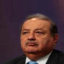

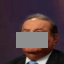

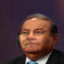

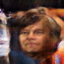

tensor(0.0175, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [1000/30000], Loss: 0.01754482854320536


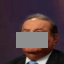

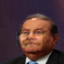

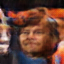

tensor(0.0140, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0111]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [2000/30000], Loss: 0.013990340832798598


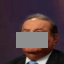

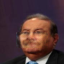

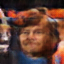

tensor(0.0133, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0119]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [3000/30000], Loss: 0.01326183189743188


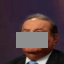

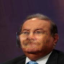

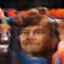

tensor(0.0131, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0088]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [4000/30000], Loss: 0.013149781509672455


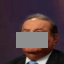

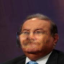

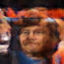

tensor(0.0119, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0093]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [5000/30000], Loss: 0.011851315479541352


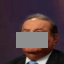

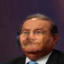

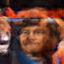

tensor(0.0117, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0253]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [6000/30000], Loss: 0.011650489355076966


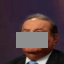

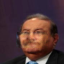

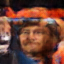

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0086]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [7000/30000], Loss: 0.01130067931655059


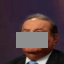

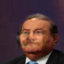

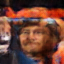

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0072]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [8000/30000], Loss: 0.011309543195839156


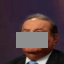

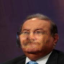

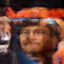

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0070]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [9000/30000], Loss: 0.011322458524420964


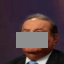

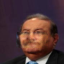

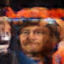

tensor(0.0114, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0073]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [10000/30000], Loss: 0.011376099208281866


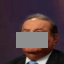

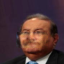

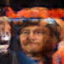

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0074]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [11000/30000], Loss: 0.011311606434158211


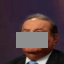

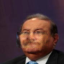

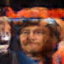

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0072]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [12000/30000], Loss: 0.011302776177818014


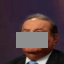

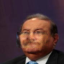

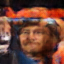

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0069]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [13000/30000], Loss: 0.01132049947438422


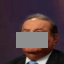

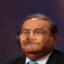

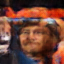

tensor(0.0117, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0075]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [14000/30000], Loss: 0.011670496508459118


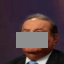

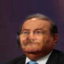

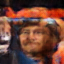

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0073]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [15000/30000], Loss: 0.011300494131542512


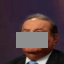

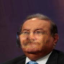

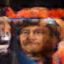

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [16000/30000], Loss: 0.011280136630160772


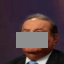

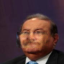

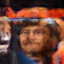

tensor(0.0114, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0073]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [17000/30000], Loss: 0.011386761836009004


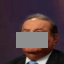

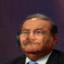

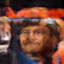

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0074]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [18000/30000], Loss: 0.011329385491783136


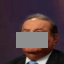

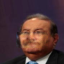

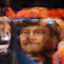

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [19000/30000], Loss: 0.011306398150827984


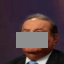

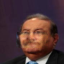

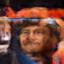

tensor(0.0114, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0072]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [20000/30000], Loss: 0.011352998251705545


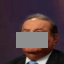

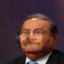

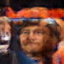

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0069]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [21000/30000], Loss: 0.01132980423743744


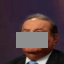

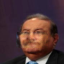

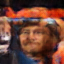

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [22000/30000], Loss: 0.011337451233970033


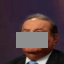

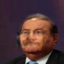

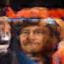

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0072]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [23000/30000], Loss: 0.011292036614325832


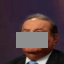

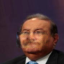

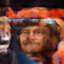

tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration [24000/30000], Loss: 0.011296612448655718


KeyboardInterrupt: 

In [278]:
# load image
path_to_img = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000231.jpg"
for i, (real_images, _) in enumerate(data_loader):
    img = real_images.cuda()
    break
    
masked_img = img * mask
original_blacked_img = img.cpu() * (1-org_mask)
original_blacked_img = original_blacked_img.cuda()
    
# show image
save_image(img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
disp_img = Image.open(f"/kaggle/working/temp.png")
display(disp_img)

# Initialize the latent vector z with random noise
noise = (2 * torch.rand((1, Generator.LATENT_DIM, 1, 1), dtype=torch.float32)) - 1
noise = noise.cuda()
noise.requires_grad = True  # Ensure gradients are tracked


# Set up the optimizer for z
optimizer = torch.optim.Adam([noise], lr=0.03)

# Define the number of iterations for optimization

lambda_recon = 100.0
lambda_adv = 0

generator.eval()
discriminator.eval()

for iteration in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    # Generate an image from the latent vector z
    generated_img = generator(noise)
    discriminator_output = discriminator(generated_img)

    # Compute the loss between the generated image and the corrupted image
    recon_loss = criterion(generated_img * mask, masked_img)
    
    adv_loss = bce_criterion(discriminator_output, torch.ones_like(discriminator_output))

    # Total loss
    loss = lambda_recon * recon_loss + lambda_adv * adv_loss
    # Backpropagate the loss
    loss.backward()

    # Update the latent vector z
    optimizer.step()

    # Print the loss every 1000 iterations
    if (iteration + 1) % 1000 == 0:
        # Apply the mask
        generated_img_masked = generated_img.clone()
        generated_img_masked *= org_mask_cuda
        generated_img_masked += original_blacked_img
        
        
        save_image(original_blacked_img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
        disp_img = Image.open(f"/kaggle/working/temp.png")
        display(disp_img)
        save_image(generated_img_masked, f"/kaggle/working/final_{iteration}.png", nrow=5, normalize=True)
        disp = Image.open(f"/kaggle/working/final_{iteration}.png")
        display(disp)
        save_image(generated_img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
        disp_img = Image.open(f"/kaggle/working/temp.png")
        display(disp_img)
        print(loss, discriminator(generated_img))
        print(f"Iteration [{iteration+1}/{NUM_ITERATIONS}], Loss: {loss.item()}")

